In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift.binary import EDDM
from sail.telemetry import TracingClient
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.drift_detection.drift_detector import SAILDriftDetector
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps, scoring=metrics.Accuracy, verbosity_level=1, verbosity_interval=1)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance


In [6]:
# tracer = TracingClient(service_name="SAIL_Testing", otlp_endpoint="http://localhost:4318")

In [7]:
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "num_cpus_per_trial": 1,
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=SAILDriftDetector(model=EDDM(), drift_param="score"),
    pipeline_strategy="DetectAndIncrement",
    verbosity_level=1, 
    verbosity_interval=1,
    tensorboard_log_dir=None,
    tracer=None # tracer
)

[2023-10-02 01:55:07:579] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [8]:
y_preds = []
y_true = []
batch_size = 50

with tracer.trace_as_current_span(span_name="Pipeline-Train"):
    for start in range(0, 2000, batch_size):

        end = start + batch_size

        X_train = X.iloc[start:end]
        y_train = y.iloc[start:end]

        if end > 1000: # search_data_size is 1000
            preds = auto_pipeline.predict(X_train)
            if preds is not None:
                y_preds.extend(list(preds))
                y_true.extend(list(y_train))

        auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


[2023-10-02 01:55:21:913] - INFO - SAIL (PipelineStrategy) - Pipeline tuning completed. Disconnecting Ray cluster...
[2023-10-02 01:55:21:914] - INFO - SAIL (PipelineStrategy) - Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    ),
                                   metric=Accuracy: 0.00%,
                                   warning_detector=ADWIN (
      delta=0.01
      clock=32
      max_buckets=5
      min_window_length=5
      grace_period=10
    )), 'classifier__n_models': 10}

    
>> Epoch: 21 | Samples Seen: 1000 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.94]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch S

#### Save model


In [9]:
auto_pipeline.save_model(".")

[2023-10-02 01:55:28:589] - INFO - SAIL (SAILModel) - Model saved successfully.


'./sail_auto_pipeline'

#### Load model


In [10]:
new_auto_pipeline = SAILAutoPipeline.load_model(".")

[2023-10-02 01:55:28:604] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']
[2023-10-02 01:55:28:605] - INFO - SAIL (TensorboardWriter) - Sending training output to Tensorboard logs. Please run `tensorboard --logdir /Users/dhaval/Projects/SAIL/sail/LOGS/Training_Logs` in terminal to start tensorboard server and track training progress.
[2023-10-02 01:55:28:681] - INFO - SAIL (SAILModel) - Model loaded successfully.
SAIL Pipeline Progressive Score: 100%========== [Points: 1850/1850, Elapsed:0.0033s, Metric=Accuracy, Batch Size=1850, P_Score=0.936]


#### Continue training using the load model


In [11]:
for start in range(1501, 3001, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = new_auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    new_auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])



    
>> Epoch: 41 | Samples Seen: 2000 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0022s, Metric=Accuracy, Batch Size=50, P_Score=0.936]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.043s, Batch Size=50, P_Score=0.936]             

    
>> Epoch: 42 | Samples Seen: 2050 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.937]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.039s, Batch Size=50, P_

#### Classification Report


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1654
           1       0.91      0.85      0.88       846

    accuracy                           0.92      2500
   macro avg       0.92      0.90      0.91      2500
weighted avg       0.92      0.92      0.92      2500



#### Plot confusion matrix


<Axes: >

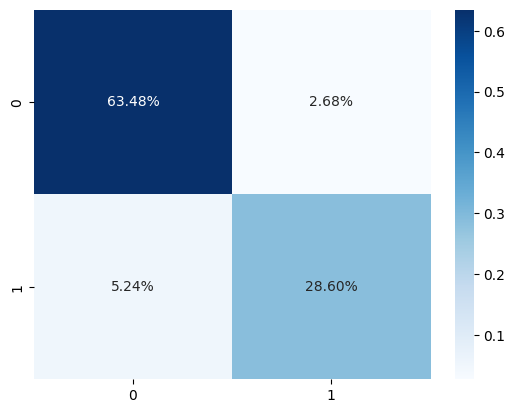

In [13]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')